# Recommendation System - Hệ thống gợi ý cầu thủ

Notebook này thực hiện Recommendation System để gợi ý cầu thủ dựa trên:
1. Tìm cầu thủ tương tự (Similarity-based)
2. Gợi ý cầu thủ cho đội bóng (Team needs-based)
3. Gợi ý dựa trên phong cách chơi (Style-based)

## Mục tiêu:
- Tìm cầu thủ thay thế tương tự
- Gợi ý cầu thủ cho đội bóng
- Tìm cầu thủ phù hợp với phong cách mong muốn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from recommendation_system import (
    find_similar_players, recommend_players_by_team_needs,
    recommend_players_by_style, create_player_profile
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Đã import các modules cần thiết")


✅ Đã import các modules cần thiết


## 1. Load dữ liệu


In [2]:
# Load dữ liệu
try:
    players_df = pd.read_excel('../data/players_processed.xlsx')
    print(f"✅ Đã load dữ liệu cầu thủ: {players_df.shape}")
except:
    from data_preprocessing import load_data, feature_engineering_players, prepare_data_for_analysis
    data = load_data()
    players_df = feature_engineering_players(data['players'])
    players_df = prepare_data_for_analysis(players_df)
    print(f"✅ Đã load và xử lý: {players_df.shape}")

# Hiển thị một số cầu thủ để tham khảo
if 'Player' in players_df.columns:
    print("\n📋 Một số cầu thủ trong dataset:")
    print(players_df[['Player', 'Pos', 'Squad']].head(10))


✅ Đã load dữ liệu cầu thủ: (574, 146)

📋 Một số cầu thủ trong dataset:
                  Player Pos            Squad
0        Aaron Cresswell  DF         West Ham
1         Aaron Ramsdale  GK      Southampton
2      Aaron Wan-Bissaka  DF         West Ham
3     Abdoulaye Doucouré  MF          Everton
4     Abdukodir Khusanov  DF  Manchester City
5  Abdul Fatawu Issahaku  FW   Leicester City
6         Adam Armstrong  FW      Southampton
7           Adam Lallana  MF      Southampton
8             Adam Smith  DF      Bournemouth
9           Adam Webster  DF         Brighton


## 2. Tìm cầu thủ tương tự (Similarity-based Recommendation)


TÌM CẦU THỦ TƯƠNG TỰ

🎯 Tìm cầu thủ tương tự với: Erling Haaland

✅ Tìm thấy 10 cầu thủ tương tự:

                   Player Pos           Squad  Similarity  shooting_Standard_Gls  passing_Ast
252  Jean-Philippe Mateta  FW  Crystal Palace    0.883727                     14            2
18         Alexander Isak  FW   Newcastle Utd    0.859139                     23            6
434         Ollie Watkins  FW     Aston Villa    0.827002                     16            8
456          Raúl Jiménez  FW          Fulham    0.816172                     12            3
564           Yoane Wissa  FW       Brentford    0.789317                     19            4
298           Kai Havertz  FW         Arsenal    0.769254                      9            3
142       Dominic Solanke  FW       Tottenham    0.768886                      9            3
239           Jamie Vardy  FW  Leicester City    0.754015                      9            4
420       Nicolas Jackson  FW         Chelsea    0.7492

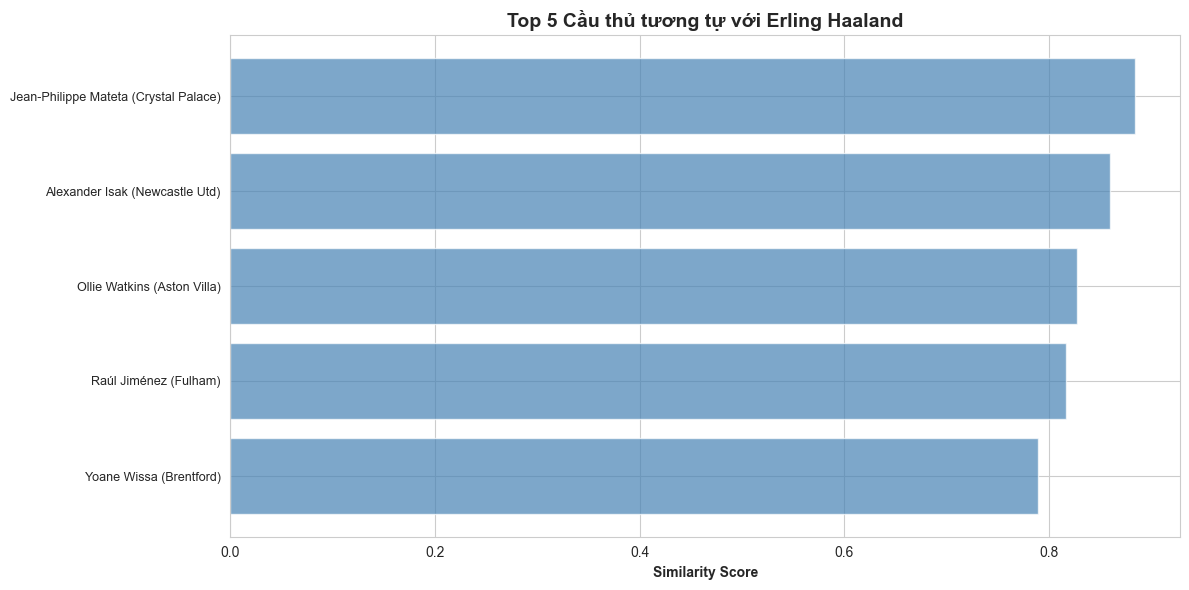


✅ Đã lưu kết quả


In [3]:
# Ví dụ: Tìm cầu thủ tương tự với một cầu thủ cụ thể
print("="*70)
print("TÌM CẦU THỦ TƯƠNG TỰ")
print("="*70)

# Chọn một cầu thủ để tìm tương tự (có thể thay đổi)
# Ví dụ: Tìm cầu thủ có tên chứa "Haaland" hoặc "Salah"
example_players = []
if 'Player' in players_df.columns:
    # Tìm một số cầu thủ nổi tiếng
    for name in ['Haaland', 'Salah', 'Kane', 'Son', 'De Bruyne']:
        matches = players_df[players_df['Player'].str.contains(name, case=False, na=False)]
        if len(matches) > 0:
            example_players.append(matches.iloc[0]['Player'])

if len(example_players) > 0:
    target_player = example_players[0]
    print(f"\n🎯 Tìm cầu thủ tương tự với: {target_player}")
    
    recommendations, player_info = find_similar_players(
        players_df, target_player, n_recommendations=10, same_position=True
    )
    
    if recommendations is not None and len(recommendations) > 0:
        print(f"\n✅ Tìm thấy {len(recommendations)} cầu thủ tương tự:")
        print("\n" + recommendations.to_string())
        
        # Visualize
        fig, ax = plt.subplots(figsize=(12, 6))
        top_5 = recommendations.head(5)
        ax.barh(range(len(top_5)), top_5['Similarity'], color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(top_5)))
        ax.set_yticklabels([f"{row['Player']} ({row.get('Squad', 'N/A')})" 
                            for _, row in top_5.iterrows()], fontsize=9)
        ax.set_xlabel('Similarity Score', fontweight='bold')
        ax.set_title(f'Top 5 Cầu thủ tương tự với {target_player}', fontweight='bold', fontsize=14)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.savefig('../results/recommendation_system/similar_players.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Lưu kết quả
        recommendations.to_csv('../results/recommendation_system/similar_players_recommendations.csv', index=False)
        print("\n✅ Đã lưu kết quả")
else:
    print("⚠️ Không tìm thấy cầu thủ mẫu. Hãy nhập tên cầu thủ cụ thể.")


GỢI Ý CẦU THỦ CHO ĐỘI BÓNG

📋 Các đội có trong dataset: ['West Ham', 'Southampton', 'Everton', 'Manchester City', 'Leicester City']

🎯 Gợi ý cầu thủ cho đội: West Ham

📊 Top 5 cầu thủ vị trí FW:
             Player Pos            Squad  Recommendation_Score  shooting_Standard_Gls  passing_Ast  shooting_Expected_xG  passing_xAG
398   Mohamed Salah  FW        Liverpool                  86.4                     29           18                  25.2         14.2
18   Alexander Isak  FW    Newcastle Utd                  53.6                     23            6                  20.3          4.3
162  Erling Haaland  FW  Manchester City                  50.0                     22            3                  22.0          3.0
74     Bryan Mbeumo  FW        Brentford                  47.6                     20            7                  12.3          8.3
564     Yoane Wissa  FW        Brentford                  44.1                     19            4                  18.5          2.6



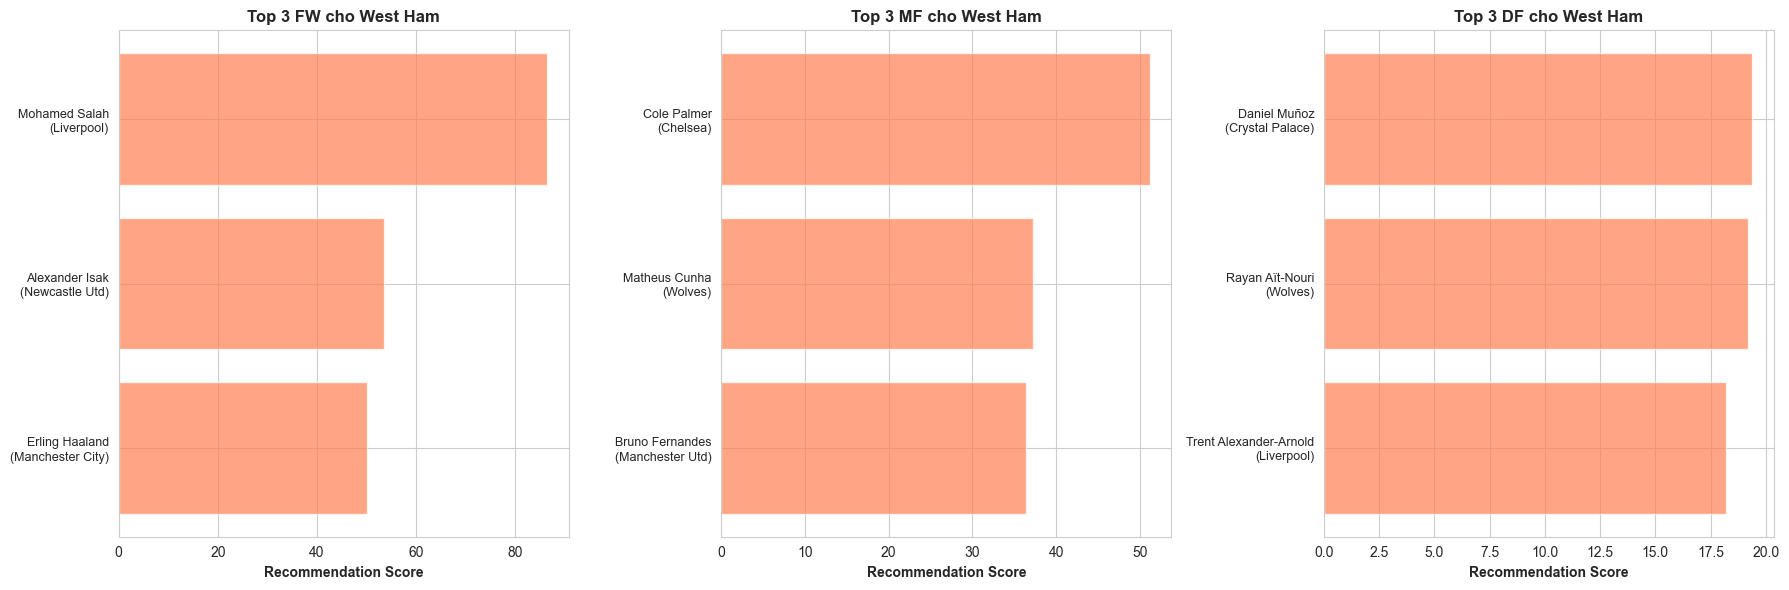


✅ Đã lưu kết quả


In [4]:
# Gợi ý cầu thủ cho đội bóng dựa trên nhu cầu
print("="*70)
print("GỢI Ý CẦU THỦ CHO ĐỘI BÓNG")
print("="*70)

# Lấy danh sách các đội
if 'Squad' in players_df.columns:
    teams = players_df['Squad'].unique()[:5]  # Lấy 5 đội đầu tiên
    print(f"\n📋 Các đội có trong dataset: {list(teams)}")
    
    # Ví dụ: Gợi ý cầu thủ cho một đội
    if len(teams) > 0:
        target_team = teams[0]
        print(f"\n🎯 Gợi ý cầu thủ cho đội: {target_team}")
        
        # Gợi ý theo từng vị trí
        positions = ['FW', 'MF', 'DF']
        all_recommendations = {}
        
        for pos in positions:
            recommendations = recommend_players_by_team_needs(
                players_df, target_team, position=pos, n_recommendations=5
            )
            if recommendations is not None and len(recommendations) > 0:
                all_recommendations[pos] = recommendations
                print(f"\n📊 Top 5 cầu thủ vị trí {pos}:")
                print(recommendations.to_string())
        
        # Visualize
        if len(all_recommendations) > 0:
            fig, axes = plt.subplots(1, len(all_recommendations), figsize=(6*len(all_recommendations), 6))
            if len(all_recommendations) == 1:
                axes = [axes]
            
            for idx, (pos, recs) in enumerate(all_recommendations.items()):
                ax = axes[idx]
                top_3 = recs.head(3)
                ax.barh(range(len(top_3)), top_3['Recommendation_Score'], color='coral', alpha=0.7)
                ax.set_yticks(range(len(top_3)))
                ax.set_yticklabels([f"{row['Player']}\n({row.get('Squad', 'N/A')})" 
                                   for _, row in top_3.iterrows()], fontsize=9)
                ax.set_xlabel('Recommendation Score', fontweight='bold')
                ax.set_title(f'Top 3 {pos} cho {target_team}', fontweight='bold')
                ax.invert_yaxis()
            
            plt.tight_layout()
            plt.savefig('../results/recommendation_system/team_recommendations.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Lưu kết quả
            for pos, recs in all_recommendations.items():
                recs.to_csv(f'../results/recommendation_system/team_{target_team}_{pos}_recommendations.csv', index=False)
            print("\n✅ Đã lưu kết quả")
else:
    print("⚠️ Không có dữ liệu về đội bóng")


GỢI Ý DỰA TRÊN PHONG CÁCH CHƠI

📊 Các chỉ số có sẵn: ['90s_shooting', 'shooting_Standard_Gls', 'shooting_Standard_Sh', 'shooting_Standard_SoT', 'shooting_Standard_SoT%', 'shooting_Standard_Sh/90', 'shooting_Standard_SoT/90', 'shooting_Standard_G/Sh', 'shooting_Standard_G/SoT', 'shooting_Standard_Dist']...

🎯 Tìm cầu thủ với phong cách:
  - Goals: ~2.0
  - Assists: ~2.0

✅ Tìm thấy 10 cầu thủ phù hợp:
                Player Pos            Squad  Similarity  shooting_Standard_Gls  passing_Ast
250     Jayden Meghoma  DF        Brentford    0.991191                      0            0
249       Jayden Danns  MF        Liverpool    0.991160                      0            0
365      Mason Holgate  FW          Everton    0.991143                      0            0
259   Jeremy Sarmiento  MF         Brighton    0.991114                      0            0
551     Will Lankshear  FW        Tottenham    0.991111                      0            0
375     Mathis Amougou  MF          Chelsea 

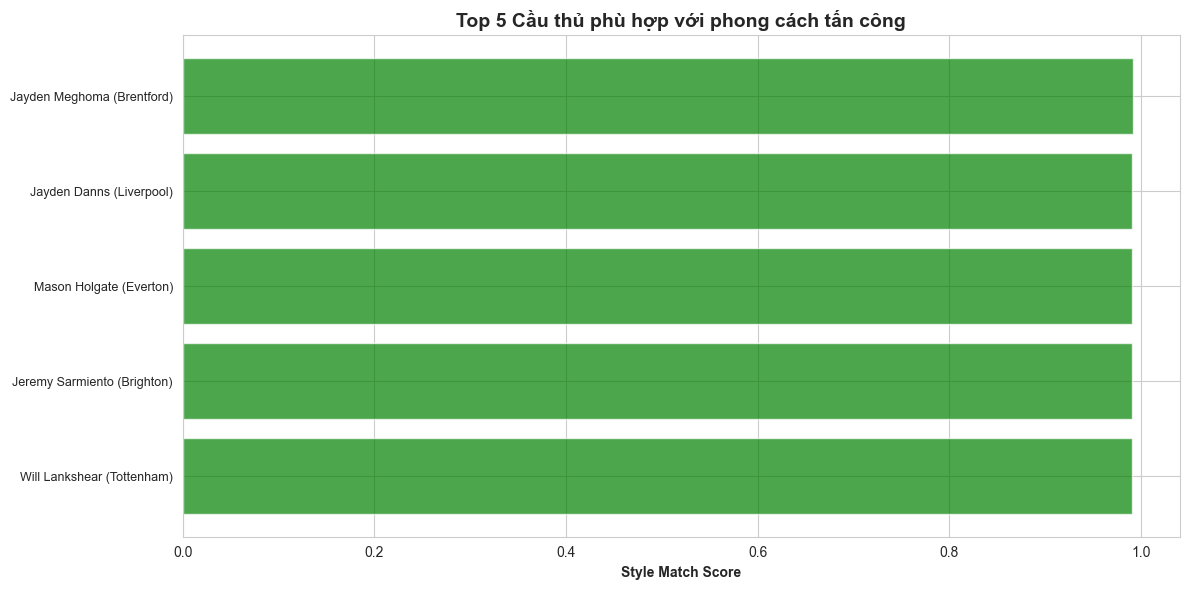


✅ Đã lưu kết quả


In [5]:
# Gợi ý cầu thủ dựa trên phong cách chơi mong muốn
print("="*70)
print("GỢI Ý DỰA TRÊN PHONG CÁCH CHƠI")
print("="*70)

# Tìm các cột chỉ số có sẵn
available_cols = [c for c in players_df.columns if any(kw in c.lower() 
    for kw in ['gls', 'ast', 'xg', 'xa', 'sh', 'sot', 'pass', 'tkl'])]

print(f"\n📊 Các chỉ số có sẵn: {available_cols[:10]}...")

# Ví dụ: Tìm cầu thủ có phong cách tấn công (nhiều goals và assists)
# Tìm giá trị trung bình để làm mục tiêu
if len(available_cols) > 0:
    # Tìm cột goals và assists
    goal_col = None
    assist_col = None
    
    for col in available_cols:
        if 'gls' in col.lower() and goal_col is None:
            goal_col = col
        if 'ast' in col.lower() and assist_col is None:
            assist_col = col
    
    if goal_col and assist_col:
        # Tính giá trị trung bình
        avg_goals = players_df[goal_col].quantile(0.75)  # Top 25%
        avg_assists = players_df[assist_col].quantile(0.75)
        
        print(f"\n🎯 Tìm cầu thủ với phong cách:")
        print(f"  - Goals: ~{avg_goals:.1f}")
        print(f"  - Assists: ~{avg_assists:.1f}")
        
        target_style = {
            goal_col: avg_goals,
            assist_col: avg_assists
        }
        
        recommendations = recommend_players_by_style(
            players_df, target_style, n_recommendations=10
        )
        
        if recommendations is not None and len(recommendations) > 0:
            print(f"\n✅ Tìm thấy {len(recommendations)} cầu thủ phù hợp:")
            print(recommendations.to_string())
            
            # Visualize
            fig, ax = plt.subplots(figsize=(12, 6))
            top_5 = recommendations.head(5)
            ax.barh(range(len(top_5)), top_5['Similarity'], color='green', alpha=0.7)
            ax.set_yticks(range(len(top_5)))
            ax.set_yticklabels([f"{row['Player']} ({row.get('Squad', 'N/A')})" 
                                for _, row in top_5.iterrows()], fontsize=9)
            ax.set_xlabel('Style Match Score', fontweight='bold')
            ax.set_title('Top 5 Cầu thủ phù hợp với phong cách tấn công', fontweight='bold', fontsize=14)
            ax.invert_yaxis()
            plt.tight_layout()
            plt.savefig('../results/recommendation_system/style_based_recommendations.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Lưu kết quả
            recommendations.to_csv('../results/recommendation_system/style_based_recommendations.csv', index=False)
            print("\n✅ Đã lưu kết quả")
else:
    print("⚠️ Không tìm thấy các chỉ số phù hợp")


## 5. Tạo Player Profile


PLAYER PROFILE

👤 Profile của: Erling Haaland

📋 Thông tin cơ bản:
  Player: Erling Haaland
  Position: FW
  Team: Manchester City
  Age: 24
  Nation: NOR

📊 Chỉ số quan trọng:
  Goals: 22.00
  Assists: 3.00
  xG: 22.00
  xA: 3.00
  Shots: 30.40
  Shots on Target: 55.00


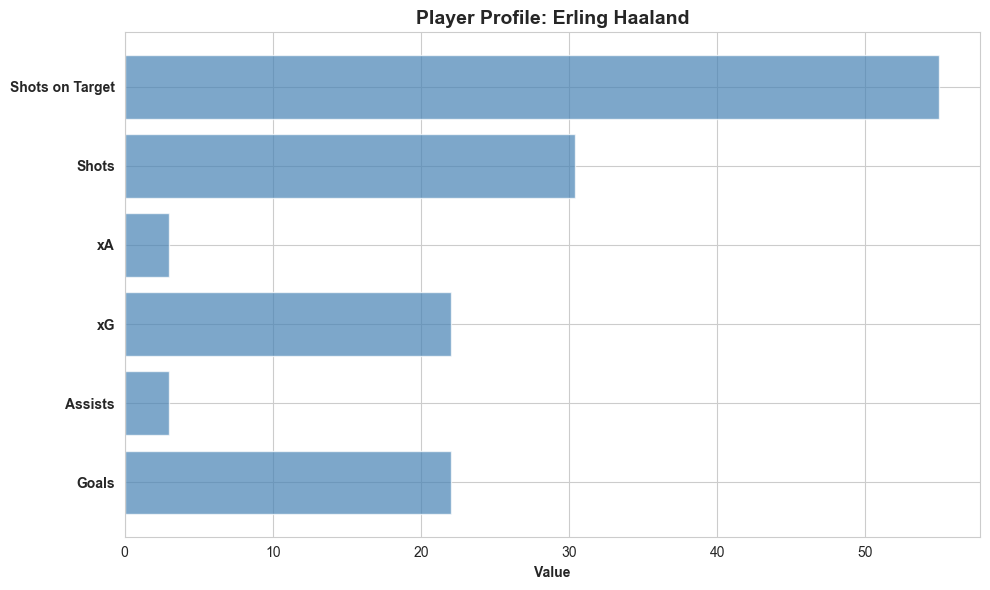

In [6]:
# Tạo profile chi tiết cho một cầu thủ
print("="*70)
print("PLAYER PROFILE")
print("="*70)

# Chọn một cầu thủ để xem profile
if 'Player' in players_df.columns and len(example_players) > 0:
    target_player = example_players[0]
    print(f"\n👤 Profile của: {target_player}")
    
    profile = create_player_profile(players_df, target_player)
    
    if profile:
        print("\n📋 Thông tin cơ bản:")
        for key, value in profile.items():
            if key != 'Stats':
                print(f"  {key}: {value}")
        
        if 'Stats' in profile:
            print("\n📊 Chỉ số quan trọng:")
            for stat, value in profile['Stats'].items():
                print(f"  {stat}: {value:.2f}")
        
        # Visualize stats
        if 'Stats' in profile and len(profile['Stats']) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            stats = profile['Stats']
            ax.barh(range(len(stats)), list(stats.values()), color='steelblue', alpha=0.7)
            ax.set_yticks(range(len(stats)))
            ax.set_yticklabels(list(stats.keys()), fontweight='bold')
            ax.set_xlabel('Value', fontweight='bold')
            ax.set_title(f'Player Profile: {target_player}', fontweight='bold', fontsize=14)
            plt.tight_layout()
            plt.savefig('../results/recommendation_system/player_profile.png', dpi=300, bbox_inches='tight')
            plt.show()
else:
    print("⚠️ Không có dữ liệu cầu thủ")
